In [1]:
import os
import sys
import datetime

import pickle
import numpy as np
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.deep_learning_models.SRCNN_model import SRCNNModel
from SRModels.constants import SRCNN_PATCH_SIZE, SRCNN_STRIDE, RANDOM_SEED

In [2]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))
INTERP_MAP_PATH = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/interpolation_map.pkl"))

In [3]:
# X -> Low-resolution patches (model input) (Low-resolution images with same size as Y but noised)
# Y -> High-resolution patches (target)
X, Y, hr_h, hr_w = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="srcnn", patch_size=SRCNN_PATCH_SIZE, stride=SRCNN_STRIDE, interpolation_map_path=INTERP_MAP_PATH)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X shape: (89768, 64, 64, 3), Y shape: (89768, 64, 64, 3)
X_train shape: (64632, 64, 64, 3), Y_train shape: (64632, 64, 64, 3)
X_val shape: (7182, 64, 64, 3), Y_val shape: (7182, 64, 64, 3)
X_test shape: (17954, 64, 64, 3), Y_test shape: (17954, 64, 64, 3)


X_train range: [0.0000, 1.0000]
Y_train range: [0.0000, 1.0000]
NaN in X_train: False, NaN in Y_train: False


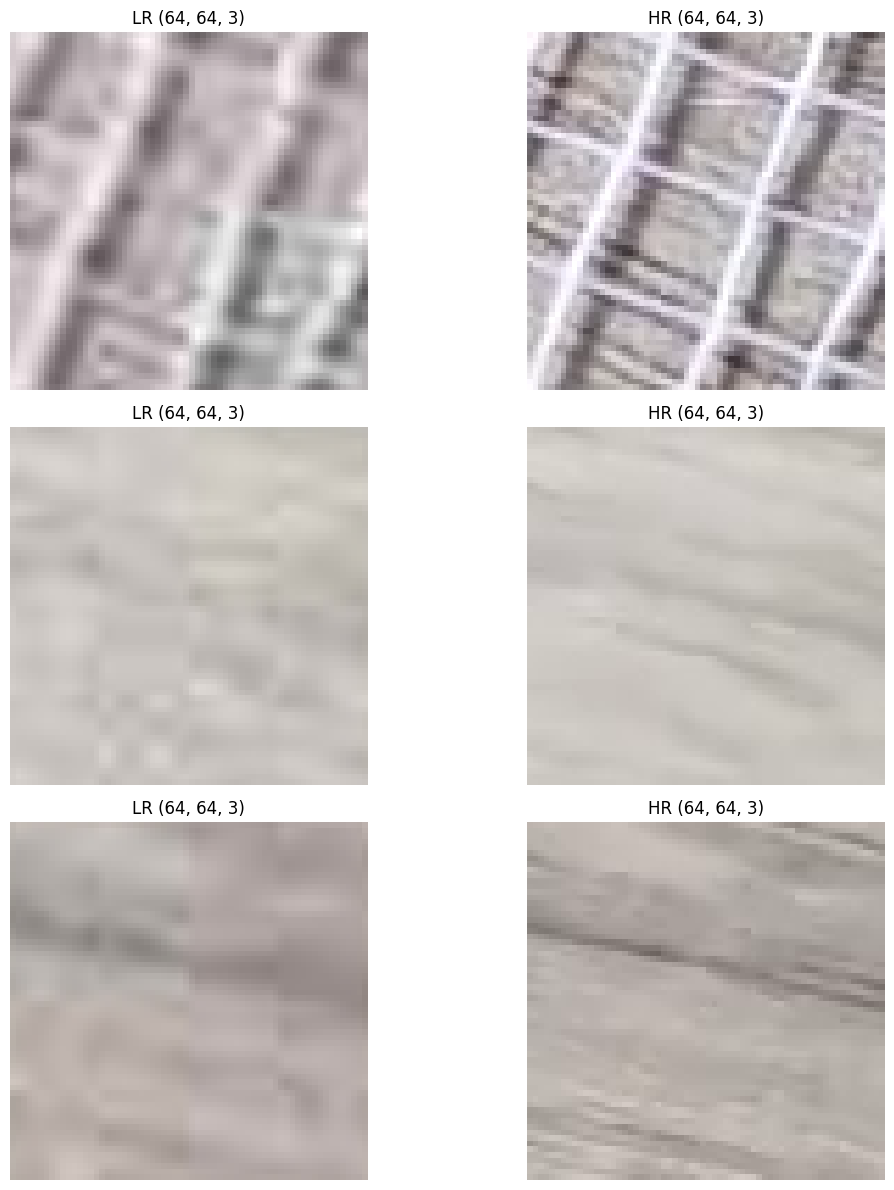

In [4]:
# Verificar rango y alineamiento de datos
import matplotlib.pyplot as plt
import numpy as np

# Verificar rangos
print(f"X_train range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")
print(f"Y_train range: [{np.min(Y_train):.4f}, {np.max(Y_train):.4f}]")
print(f"NaN in X_train: {np.isnan(X_train).any()}, NaN in Y_train: {np.isnan(Y_train).any()}")

# Visualizar algunos pares aleatorios
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    axes[i, 0].imshow(X_train[idx])
    axes[i, 0].set_title(f"LR {X_train[idx].shape}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(Y_train[idx])
    axes[i, 1].set_title(f"HR {Y_train[idx].shape}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
model = SRCNNModel()

model.setup_model(input_shape=X_train.shape[1:], learning_rate=1e-4, loss="mean_squared_error")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        23424     
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        3104      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         2403      
                                                                 
Total params: 28,931
Trainable params: 28,931
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Train SRCNN and capture callbacks for metrics
time_cb, mem_cb = model.fit(
    X_train, Y_train, X_val, Y_val,
    batch_size=32,
    epochs=100,
    use_augmentation=True
)

Training on GPU: /physical_device:GPU:0
Epoch 1/100
2020/2020 [==============================] - 84s 39ms/step - loss: 0.0812 - psnr: 20.6351 - ssim: 0.4098 - val_loss: 0.0540 - val_psnr: 24.0713 - val_ssim: 0.5232 - lr: 1.0000e-04 - epoch_time_sec: 84.4924 - gpu_mean_current_mb: 336.9135 - gpu_peak_mb: 947.6008
Epoch 2/100
2020/2020 [==============================] - 45s 22ms/step - loss: 0.0749 - psnr: 21.3565 - ssim: 0.4146 - val_loss: 0.0547 - val_psnr: 23.9809 - val_ssim: 0.5192 - lr: 1.0000e-04 - epoch_time_sec: 45.0167 - gpu_mean_current_mb: 673.7119 - gpu_peak_mb: 947.6008
Epoch 3/100
2020/2020 [==============================] - 45s 22ms/step - loss: 0.0745 - psnr: 21.3935 - ssim: 0.4152 - val_loss: 0.0544 - val_psnr: 24.0224 - val_ssim: 0.5283 - lr: 1.0000e-04 - epoch_time_sec: 44.8206 - gpu_mean_current_mb: 673.7119 - gpu_peak_mb: 947.6008
Epoch 4/100
2019/2020 [============================>.] - ETA: 0s - loss: 0.0744 - psnr: 21.4112 - ssim: 0.4154
Epoch 4: ReduceLROnPlateau 

In [7]:
# Evaluate and prepare metrics dictionary
results = model.evaluate(X_test, Y_test)
metrics_dict = {
    "eval_loss": float(results[0]),
    "eval_psnr": float(results[1]),
    "eval_ssim": float(results[2]),
    "epoch_time_sec": time_cb.mean_time_value(),
    "memory": mem_cb.as_dict()
}
print(metrics_dict)

562/562 [==============================] - 5s 9ms/step - loss: 0.0531 - psnr: 24.2423 - ssim: 0.5399
Loss: 0.0531, PSNR: 24.24 dB, SSIM: 0.5399
{'eval_loss': 0.05313633382320404, 'eval_psnr': 24.242305755615234, 'eval_ssim': 0.5398855209350586, 'epoch_time_sec': 48.717225255554595, 'memory': {'gpu_mean_current_mb': 636.2901475694445, 'gpu_peak_mb': 947.600830078125}}


In [8]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the trained model
model.save(directory=f"models/SRCNN/SRCNN_{timestamp}", timestamp=timestamp)

# Save hr_h and hr_w for later use in the reconstruction of the images
with open(os.path.abspath(os.path.join(os.getcwd(), f"models/SRCNN/SRCNN_{timestamp}/SRCNN_{timestamp}_hrh_hrw.pkl")), "wb") as f:
    pickle.dump((hr_h, hr_w), f)

Model saved to models/SRCNN/SRCNN_20250909_000725\SRCNN_20250909_000725.h5


In [9]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/SRCNN/SRCNN_{timestamp}/SRCNN_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\SRCNN\SRCNN_20250909_000725\SRCNN_20250909_000725_metrics.pkl
